# **Correction**: Time Series Forecasting Using RNN

## Python Packages Required

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import h5py  # Output network weights in HDF5 format during checkpointing

In [4]:
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Model
from keras.layers import Input, Dense, Embedding, Flatten, AveragePooling1D
from keras.layers import SimpleRNN, LSTM, Bidirectional, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D, MaxPooling1D

___

## Dataset and Objective

The ultimate goal of the lab is to study the `covid19` dataset that compiles the number of confirmed cases and fatalities for different countries and province states around the world.

In [80]:
covid19 = pd.read_csv('covid19.csv', parse_dates=[3], infer_datetime_format=True)

print("covid19.shape", covid19.shape)
display(covid19.dtypes)
covid19.head()

covid19.shape (35995, 6)


Id                         int64
Province_State            object
Country_Region            object
Date              datetime64[ns]
ConfirmedCases           float64
Fatalities               float64
dtype: object

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In particular, the following states can be observed:

In [81]:
print(covid19["Province_State"].unique())

[nan 'Australian Capital Territory' 'New South Wales' 'Northern Territory'
 'Queensland' 'South Australia' 'Tasmania' 'Victoria' 'Western Australia'
 'Alberta' 'British Columbia' 'Manitoba' 'New Brunswick'
 'Newfoundland and Labrador' 'Northwest Territories' 'Nova Scotia'
 'Ontario' 'Prince Edward Island' 'Quebec' 'Saskatchewan' 'Yukon' 'Anhui'
 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi' 'Guizhou'
 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei' 'Hunan'
 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau' 'Ningxia'
 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan' 'Tianjin'
 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang' 'Faroe Islands' 'Greenland'
 'French Guiana' 'French Polynesia' 'Guadeloupe' 'Martinique' 'Mayotte'
 'New Caledonia' 'Reunion' 'Saint Barthelemy' 'Saint Pierre and Miquelon'
 'St Martin' 'Aruba' 'Bonaire, Sint Eustatius and Saba' 'Curacao'
 'Sint Maarten' 'Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California'
 'Colorado' 'Con

To facilitate the visualization of the dataset, we add a column to count the number of days since our first observation.

In [82]:
print(covid19['Date'].min())
covid19['Days'] = covid19['Date']-covid19['Date'].min()
covid19.head()

2020-01-22 00:00:00


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,Days
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,0 days
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,1 days
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0,2 days
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0,3 days
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0,4 days


Text(0.5, 0, 'Days')

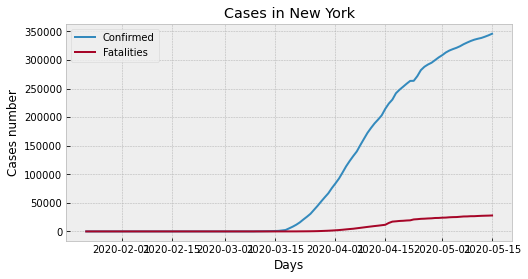

In [83]:
STATE = "New York"

df = covid19[covid19["Province_State"]==STATE]

plt.figure(figsize=(8,4))
mpl.style.use("bmh")
plt.plot(df["Date"], df['ConfirmedCases'], label='Confirmed')
plt.plot(df["Date"], df['Fatalities'], label='Fatalities')
plt.legend()
plt.title("Cases in "+STATE)
plt.ylabel("Cases number")
plt.xlabel("Days")

### Guidelines

We wish to solve the supervised learning problem corresponding to the prediction of confirmed cases for the next 10 days based on the known cases of the previous 30 days.  Once this is done, we would like to jointly predict the confirmed cases and the fatalities.

To do this, first make sure you understand the different variants of the LSTM algorithm presented below, except for the parts marked with a purple "To Go Further". If necessary, complete the relevant codes. 
Then, answer the problem posed using the codes provided.

In [84]:
confirmed = np.array(df['ConfirmedCases']).reshape(-1, 1)
fatalities = np.array(df['Fatalities']).reshape(-1, 1)

print("Confirmed cases in "+STATE+":",confirmed.shape,";  Fatalities in "+STATE+":", fatalities.shape)

Confirmed cases in New York: (115, 1) ;  Fatalities in New York: (115, 1)


### Neural Architecture

In [85]:
def build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test):
    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=inputs, outputs=predictions)

    # print the network
    model.summary()

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    es = EarlyStopping(monitor="val_loss", mode="min", patience=10)  # early stopping to prevent overfitting
    mc = ModelCheckpoint("model.hdf5", monitor="val_mae", mode="min", save_best_only=True)
    callbacks = [es, mc]

    history = model.fit(X_train[:-SPLIT], y_train[:-SPLIT], epochs=200,
                        validation_data=[X_train[-SPLIT:], y_train[-SPLIT:]],
                        callbacks=callbacks, verbose=0, shuffle=False)
    model = load_model("model.hdf5")
    y_pred = model.predict(X_test)
    
    # plot history
    plt.figure(figsize=(16,4))
    mpl.style.use("seaborn-colorblind")
    ax = plt.gca()

    if len(y_train.shape)==2:  # Univariate data
        plt.subplot(131)
        plt.plot(history.history['loss'][3:], label='loss')
        plt.plot(history.history['val_loss'][3:], label='val_loss')
        plt.legend(loc='center right')
    
        plt.subplot(132)
        plt.plot(history.history['mae'][3:], label='mae')
        plt.plot(history.history['val_mae'][3:], label='val_mae')
        plt.legend(loc='center right')
    
        plt.subplot(133)
        color = next(ax._get_lines.prop_cycler)['color']
        plt.plot(range(len(y_train)), y_train, label="train",color=color)
        color = next(ax._get_lines.prop_cycler)['color']
        plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test, label="test",color=color)
        color = next(ax._get_lines.prop_cycler)['color']
        plt.plot(range(len(y_train), len(y_train)+len(y_pred)), y_pred, label="predict",color=color)
        plt.legend(loc='upper left')
    else:
        subplot=str(y_pred.shape[1]+2)+str(y_pred.shape[1]+2)
        
        plt.subplot(int(subplot+"1"))
        plt.plot(history.history['loss'][3:], label='loss')
        plt.plot(history.history['val_loss'][3:], label='val_loss')
        plt.legend(loc='center right')
    
        plt.subplot(int(subplot+"2"))
        plt.plot(history.history['mae'][3:], label='mae')
        plt.plot(history.history['val_mae'][3:], label='val_mae')
        plt.legend(loc='center right')
    
        for i in range(y_pred.shape[1]):
            plt.subplot(int(subplot+str(i+3)))
            color = next(ax._get_lines.prop_cycler)['color']
            plt.plot(range(len(y_train)), y_train[:,i,:], label="train"+str(i),color=color)
            color = next(ax._get_lines.prop_cycler)['color']
            plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test[:,i,:], label="test"+str(i),color=color)
            color = next(ax._get_lines.prop_cycler)['color']
            plt.plot(range(len(y_train), len(y_train)+len(y_pred)), y_pred[:,i,:], label="predict"+str(i),color=color)
            plt.legend(loc='upper left')

    plt.show()
    return model

___

## LSTM Network for Univariate Time Series

LSTM can be used to model univariate time series forecasting problems. These problems consist of a single set of observations and a model is needed to learn from the past set of observations in order to forecast the next value in the sequence. Before considering our multivariate dataset, we will test different variants of the RNN algrithm, and more precisely the LSTM, on univariate synthetic data.

Be careful not to draw hasty conclusions about the relative performance of the models. The number of layers or neurons are highly variable between models.

<!-- _To do:_ time series where you want to predict, a sequence instead of a single value. -->


### Synthetic Dataset

Text(0.5, 0, '$x$')

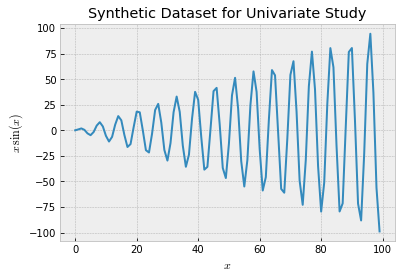

In [86]:
SIZE = 100
n_features = 1 # for univariate time series

fct = lambda x: x*np.sin(x)
time_series = [fct(x) for x in range(SIZE)]

plt.plot(time_series)
mpl.style.use("bmh")
plt.title("Synthetic Dataset for Univariate Study")
plt.ylabel("$x\,\sin(x)$")
plt.xlabel("$x$")

Consider a given univariate sequence:

`[10, 20, 30, 40, 50, 60, 70, 80, 90]`

We can divide the sequence into multiple input/output patterns called samples, where three time steps are used as input and one time step is used as output for the one-step prediction that is being learned.

`X 				y ` <br/>
`10, 20, 30		40` <br/>
`20, 30, 40		50` <br/>
`30, 40, 50		60` <br/>
`...` <br/>

The $\texttt{convert_data_univariate()}$ function below implements this behavior and will split a given univariate sequence into multiple samples where each sample has a specified number of time steps `n_in` (by default 3) and the output has also a specified number of time steps `n_out` (by default 1).

In [87]:
def convert_data_univariate(data, n_in=3, n_out=1):
    X, y = [], []
    # input sequence (t-n, ... t-1)
    for i in range(len(data)):
        # find the end of this pattern
        end_x = i + n_in
        end_y = end_x + n_out
        # check if we are beyond the sequence
        if end_y > len(data):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_x], data[end_x:end_y]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [88]:
# Split into samples
n_in, n_out = 6, 1
X, y = convert_data_univariate(time_series, n_in, n_out)

# Summarize the data
for i in range(3):
    print("-"*15)
    print("X:", X[i])
    print("y:", y[i])
print("...")

---------------
X: [ 0.          0.84147098  1.81859485  0.42336002 -3.02720998 -4.79462137]
y: [-1.67649299]
---------------
X: [ 0.84147098  1.81859485  0.42336002 -3.02720998 -4.79462137 -1.67649299]
y: [4.59890619]
---------------
X: [ 1.81859485  0.42336002 -3.02720998 -4.79462137 -1.67649299  4.59890619]
y: [7.91486597]
...


In [89]:
testAndValid = 0.1
SPLIT = int(testAndValid*len(X))

The form of the input for each sample is specified in the `input_shape` argument on the definition of the first hidden layer. The model expects the input component for training data to have the dimensions or shape `[samples, timesteps, features]` here.

In [90]:
# reshape from [samples, timesteps] into [samples, n_in, n_features]
X_train = X.reshape((X.shape[0], X.shape[1], n_features))[:-SPLIT]
X_test = X.reshape((X.shape[0], X.shape[1], n_features))[-SPLIT:]

y_train, y_test = y[:-SPLIT], y[-SPLIT:]

print("X_train:",X_train.shape,"; X_test:", X_test.shape)
print("y_train:",y_train.shape,"   ; y_test:", y_test.shape)

X_train: (85, 6, 1) ; X_test: (9, 6, 1)
y_train: (85, 1)    ; y_test: (9, 1)


### Simple RNN

In [91]:
RNN_SIZE = 30

inputs = Input(shape=(n_in, n_features))
outputs = SimpleRNN(RNN_SIZE, return_sequences=False, activation='tanh')(inputs)
predictions = Dense(n_out, activation='linear')(outputs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 30)                960       
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


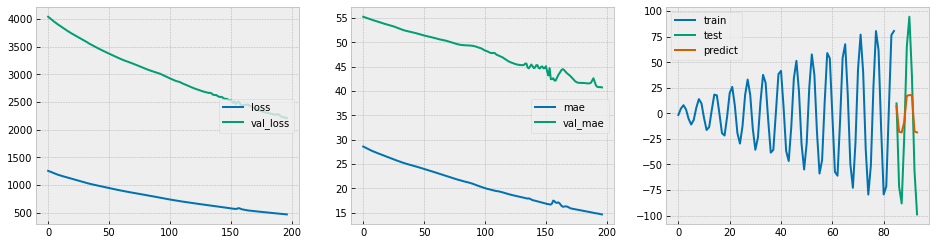

In [15]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

In [16]:
# Evaluate prediction
start = 12
y_true = fct(start+n_in)
x_input = np.array([fct(x) for x in range(start, start+n_in)])
x_input = x_input.reshape((1, n_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-17.747667]] -13.51777044189017


### Vanilla LSTM

In [17]:
LSTM_SIZE = 30

inputs = Input(shape=(n_in, n_features))
outputs = LSTM(LSTM_SIZE, return_sequences=False,recurrent_activation='sigmoid',activation='relu')(inputs)
predictions = Dense(n_out, activation='linear')(outputs)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


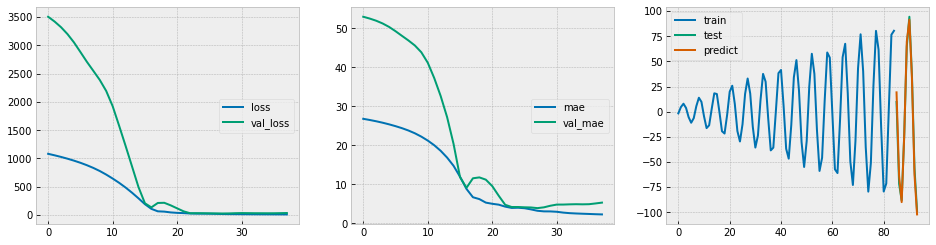

In [18]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

In [19]:
# Evaluate prediction
start = 12
y_true = fct(start+n_in)
x_input = np.array([fct(x) for x in range(start, start+n_in)])
x_input = x_input.reshape((1, n_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-5.383887]] -13.51777044189017


### Stacked Bi-LSTM

In order to improve the performance of the model, it's possible to:
- stack LSTM with `return_sequence=True` for all levels except the last one where `return_sequence=False`
- use Bi-LSTM

In [20]:
inputs = Input(shape=(n_in, n_features))
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(inputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(outputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=False, activation='relu'))(outputs)
predictions = Dense(n_out, activation='linear')(outputs)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 60)            7680      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 60)            21840     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 60)               21840     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                           

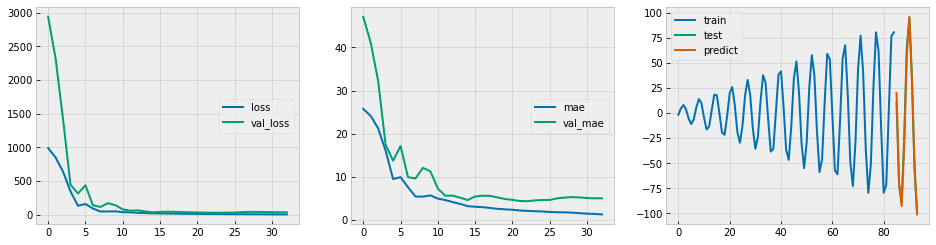

In [21]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

In [22]:
# Evaluate prediction
start = 12
y_true = fct(start+n_in)
x_input = np.array([fct(x) for x in range(start, start+n_in)])
x_input = x_input.reshape((1, n_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-10.334077]] -13.51777044189017


### Other Kind of Networks <span style="color:purple">(To Go Further)</span>

#### CNN-LSTM

A CNN model can be used in a hybrid model with an LSTM backend where the CNN is used to interpret subsequences of input that together are provided as a sequence to an LSTM model to interpret.

The first step is to split the input sequences into subsequences that can be processed by the CNN model. For example, we can first split our univariate time series data into input/output samples with four steps as input and one as output. Each sample can then be split into two sub-samples, each with two time steps. The CNN can interpret each subsequence of two time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

We can parameterize this and define the number of subsequences as `n_seq` and the number of time steps per subsequence as `n_steps`. The input data can then be reshaped to have the required structure: `[samples, subsequences, timesteps, features]`.

`n_step` is the number of time steps per subsequence.

In [23]:
# Reshape from [samples, timesteps] into [samples, subsequences, n_steps, n_features]
n_seq = 2 # subsequence size
if n_in % n_seq == 0:
    n_steps = n_in // n_seq
else:
    print("bad subsequence value")
    stop()
X_train = X.reshape((X.shape[0], n_seq, n_steps, n_features))[:-SPLIT]
X_test = X.reshape((X.shape[0], n_seq, n_steps, n_features))[-SPLIT:]

y_train = y[:-SPLIT]
y_test = y[-SPLIT:]

In [24]:
CNN_SIZE = 16

inputs = Input(shape=(n_seq,n_steps,n_features))
outputs = TimeDistributed(Conv1D(filters=CNN_SIZE, kernel_size=1, activation='relu'))(inputs)
outputs = TimeDistributed(MaxPooling1D(pool_size=2))(outputs)
outputs = TimeDistributed(Flatten())(outputs)
outputs = TimeDistributed(Flatten())(outputs)
outputs = LSTM(50, activation='relu')(outputs)
predictions = Dense(n_out, activation='linear')(outputs)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2, 3, 1)]         0         
                                                                 
 time_distributed (TimeDistr  (None, 2, 3, 16)         32        
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2, 1, 16)         0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2, 16)            0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2, 16)            0         
 tributed)                                                 

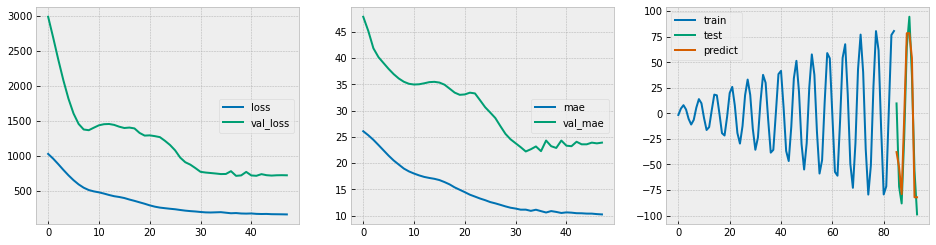

In [25]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

In [26]:
# Evaluate prediction
start = 12
y_true = fct(start+n_in)
x_input = np.array([fct(x) for x in range(start,start+n_in)])
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-5.5701737]] -13.51777044189017


#### ConvLSTM

A type of LSTM related to the CNN-LSTM is the ConvLSTM, where the convolutional reading of input is built directly into each LSTM unit.

The ConvLSTM was developed for reading two-dimensional spatial-temporal data, but can be adapted for use with univariate time series forecasting.

The layer expects input as a sequence of two-dimensional images, therefore the shape of input data must be: `[samples, timesteps, rows, columns, features]`.

For our purposes, we can split each sample into subsequences where timesteps will become the number of subsequences, or n_seq, and columns will be the number of time steps for each subsequence, or n_steps. The number of rows is fixed at 1 as we are working with one-dimensional data.

In [27]:
# reshape from [samples, timesteps] into [samples, subsequences, n_steps, n_features]
n_seq = 2 # subsequence size
if n_in % n_seq == 0:
    n_steps = n_in // n_seq
else:
    print("bad subsequence value")
    stop()
X_train = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))[:-SPLIT]
X_test = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))[-SPLIT:]

y_train = y[:-SPLIT]
y_test = y[-SPLIT:]

In [28]:
CNN_SIZE = 16

inputs = Input(shape=(n_seq, 1, n_steps, n_features))
outputs = ConvLSTM2D(filters=CNN_SIZE, kernel_size=(1,n_steps), activation='relu')(inputs)
outputs = Flatten()(outputs)
predictions = Dense(n_out, activation='linear')(outputs)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2, 1, 3, 1)]      0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 16)          3328      
                                                                 
 flatten_2 (Flatten)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,345
Trainable params: 3,345
Non-trainable params: 0
_________________________________________________________________


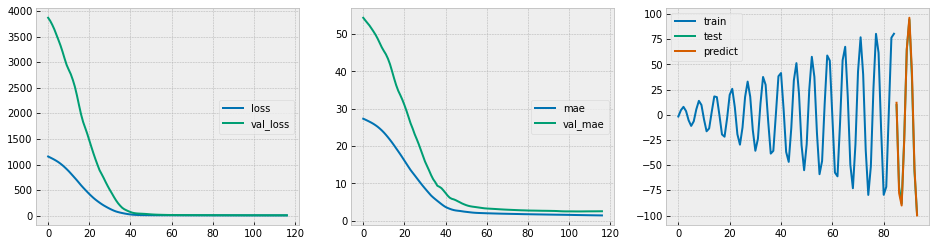

In [29]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

In [30]:
# Evaluate prediction
start = 12
y_true = fct(start+n_in)
x_input = np.array([fct(x) for x in range(start,start+n_in)])
x_input = x_input.reshape((1, n_seq, 1, n_steps, n_out))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-9.87894]] -13.51777044189017


___

## LSTM Network for Multivariate Time Series 

Multivariate time series data means data where there is more than one observation for each time step.

There are two main models that we may require with multivariate time series data; they are:

* Multiple Input Series.
* Multiple Parallel Series.

Let’s take a look at each in turn.

### Synthetic Dataset

In [31]:
fct2 = lambda x: 2*x

time_series1 = np.array([fct(x) for x in range(SIZE)])
time_series2 = np.array([fct2(x) for x in range(SIZE)])
out_seq = np.array([time_series1[i]+time_series2[i] for i in range(SIZE)])

We can reshape these three arrays of data as a single dataset where each row is a time step, and each column is a separate time series. This is a standard way of storing parallel time series in a CSV file.

In [32]:
# Convert to [rows, columns] structure
time_series1 = time_series1.reshape((len(time_series1), 1))
time_series2 = time_series2.reshape((len(time_series2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# Horizontally stack columns
dataset = np.hstack((time_series1, time_series2, out_seq))
dataset[:5]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.84147098,  2.        ,  2.84147098],
       [ 1.81859485,  4.        ,  5.81859485],
       [ 0.42336002,  6.        ,  6.42336002],
       [-3.02720998,  8.        ,  4.97279002]])

### Multiple Input Series

As with the univariate time series, we must structure these data into samples with input and output elements.

An LSTM model needs sufficient context to learn a mapping from an input sequence to an output value. LSTMs can support parallel input time series as separate variables or features. Therefore, we need to split the data into samples maintaining the order of observations across the two input sequences.

If we chose three input time steps, then the first sample would look as follows:

Input: `0,      0`</br>
`     0.841,  2`</br>
`     1.819,  4`

Output: `5.819`


In [33]:
# Split a multivariate sequence into samples
def convert_data_multipleinputseries(data, n_in=3, n_out=1):
    X, y = [], []
    # input sequence (t-n, ... t-1)
    for i in range(len(data)):
        # find the end of this pattern
        end_x = i + n_in
        end_y = end_x + n_out
        # check if we are beyond the sequence
        if end_y > len(data):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_x, :-1], data[end_x:end_y, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [34]:
n_in, n_out = 6, 1

X, y = convert_data_multipleinputseries(dataset, n_in, n_out)
# Summarize the data
for i in range(3):
    print("-"*15)
    print("X:", X[i])
    print("y:", y[i])
print("...")

# summarize the data
#for i in range(3):
#    print(X[i], y[i])
#print("...")

n_features = X.shape[-1] # in order to capture the multi-variate dimension

---------------
X: [[ 0.          0.        ]
 [ 0.84147098  2.        ]
 [ 1.81859485  4.        ]
 [ 0.42336002  6.        ]
 [-3.02720998  8.        ]
 [-4.79462137 10.        ]]
y: [10.32350701]
---------------
X: [[ 0.84147098  2.        ]
 [ 1.81859485  4.        ]
 [ 0.42336002  6.        ]
 [-3.02720998  8.        ]
 [-4.79462137 10.        ]
 [-1.67649299 12.        ]]
y: [18.59890619]
---------------
X: [[ 1.81859485  4.        ]
 [ 0.42336002  6.        ]
 [-3.02720998  8.        ]
 [-4.79462137 10.        ]
 [-1.67649299 12.        ]
 [ 4.59890619 14.        ]]
y: [23.91486597]
...


Any of the varieties of LSTMs in the previous section can be used, such as a Vanilla, Stacked, Bidirectional, CNN, or ConvLSTM model. 
We will use a Vanilla LSTM where the number of time steps and parallel series (features) are specified for the input layer via the input_shape argument.

In [35]:
inputs = Input(shape=(n_in, n_features))
outputs = LSTM(LSTM_SIZE, return_sequences=False, activation='relu')(inputs)
predictions = Dense(n_out, activation='linear')(outputs)

In [36]:
X_train, X_test = X[:-SPLIT], X[-SPLIT:]
y_train, y_test = y[:-SPLIT], y[-SPLIT:]

print("X_train:",X_train.shape,"; X_test:", X_test.shape)
print("y_train:",y_train.shape,"   ; y_test:", y_test.shape)

X_train: (85, 6, 2) ; X_test: (9, 6, 2)
y_train: (85, 1)    ; y_test: (9, 1)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 6, 2)]            0         
                                                                 
 lstm_5 (LSTM)               (None, 30)                3960      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,991
Trainable params: 3,991
Non-trainable params: 0
_________________________________________________________________


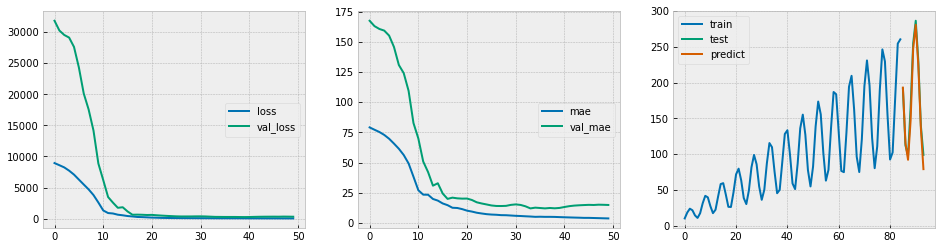

In [37]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

In [38]:
# Evaluate prediction
start = 12
y_true = fct(start+n_in)+fct2(start+n_in)

time_series1 = np.array([fct(x) for x in range(start,start+n_in)])
time_series2 = np.array([fct2(x) for x in range(start,start+n_in)])
time_series1 = time_series1.reshape((len(time_series1), 1))
time_series2 = time_series2.reshape((len(time_series2), 1))
x_input = np.hstack((time_series1, time_series2)).reshape((1, len(time_series2), -1))

yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[32.52928]] 22.48222955810983


### Multiple Parallel Series

An alternate time series problem is the case where there are multiple parallel time series and a value must be predicted for each. 
For example, given the data from the previous section:

`[ 0,      0,  0]`</br>
`[ 0.841,  2,  2.841]`</br>
`[ 1.819,  4,  8.819]`</br>
`[ 0.423,  6,  6.423]`

We may want to predict the value for each of the three time series for the next time step.This might be referred to as multivariate forecasting. Again, the data must be split into input/output samples in order to train a model. The first sample of this dataset would be:

Input:`0,      0,  0`</br>
`    0.841,  2,  2.841`</br>
`    1.819,  4,  8.819`

Output: `0.423,  6,  6.423`

In [39]:
# Split a multivariate sequence into samples
def convert_data_multiplesparallelseries(data, n_in=3, n_out=1):
    X, y = [], []
    # input sequence (t-n, ... t-1)
    for i in range(len(data)):
        # find the end of this pattern
        end_x = i + n_in
        end_y = end_x + n_out
        # check if we are beyond the sequence
        if end_y > len(data):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_x, :], data[end_x:end_y, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [40]:
n_in, n_out = 6, 1

X, y = convert_data_multiplesparallelseries(dataset, n_in, n_out)
if n_out==1:
    y = y.reshape(y.shape[0], y.shape[-1])
# Summarize the data
for i in range(3):
    print("-"*15)
    print("X:", X[i])
    print("y:", y[i])
print("...")

n_features = X.shape[-1] # in order to capture the multi-variate dimension

---------------
X: [[ 0.          0.          0.        ]
 [ 0.84147098  2.          2.84147098]
 [ 1.81859485  4.          5.81859485]
 [ 0.42336002  6.          6.42336002]
 [-3.02720998  8.          4.97279002]
 [-4.79462137 10.          5.20537863]]
y: [-1.67649299 12.         10.32350701]
---------------
X: [[ 0.84147098  2.          2.84147098]
 [ 1.81859485  4.          5.81859485]
 [ 0.42336002  6.          6.42336002]
 [-3.02720998  8.          4.97279002]
 [-4.79462137 10.          5.20537863]
 [-1.67649299 12.         10.32350701]]
y: [ 4.59890619 14.         18.59890619]
---------------
X: [[ 1.81859485  4.          5.81859485]
 [ 0.42336002  6.          6.42336002]
 [-3.02720998  8.          4.97279002]
 [-4.79462137 10.          5.20537863]
 [-1.67649299 12.         10.32350701]
 [ 4.59890619 14.         18.59890619]]
y: [ 7.91486597 16.         23.91486597]
...


Any of the varieties of LSTMs in the previous section can be used, such as a Vanilla, Stacked, Bidirectional, CNN, or ConvLSTM model. We will use a Stacked Bi-LSTM where the number of time steps and parallel series (features) are specified for the input layer via the input_shape argument. The number of parallel series is also used in the specification of the number of values to predict by the model in the output layer; again, this is three.

In [41]:
inputs = Input(shape=(n_in, n_features))
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(inputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(outputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=False, activation='relu'))(outputs)
predictions = Dense(n_features, activation='linear')(outputs)

In [42]:
X_train, X_test = X[:-SPLIT], X[-SPLIT:]
y_train, y_test = y[:-SPLIT], y[-SPLIT:]

print("X_train:",X_train.shape,"; X_test:", X_test.shape)
print("y_train:",y_train.shape,"   ; y_test:", y_test.shape)

X_train: (85, 6, 3) ; X_test: (9, 6, 3)
y_train: (85, 3)    ; y_test: (9, 3)


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 6, 60)            8160      
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 6, 60)            21840     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 60)               21840     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 3)                 183       
                                                           

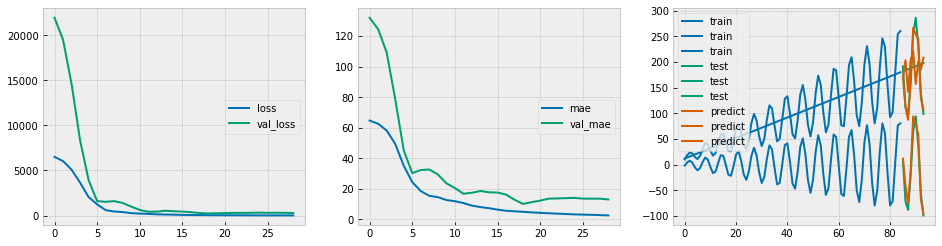

In [43]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

In [44]:
# Evaluate prediction
start = 12
y_true = [fct(start+n_in),fct2(start+n_in),fct(start+n_in)+fct2(start+n_in)]

time_series1 = np.array([fct(x) for x in range(start,start+n_in)]).reshape((-1, 1))
time_series2 = np.array([fct2(x) for x in range(start,start+n_in)]).reshape((-1, 1))
out_seq = np.array([time_series1[i]+time_series2[i] for i in range(len(time_series2))]).reshape((-1, 1))
x_input = np.hstack((time_series1, time_series2,out_seq)).reshape((1, len(time_series1), -1))

yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-2.2608166 37.77737   33.59981  ]] [-13.51777044189017, 36, 22.48222955810983]


___

## Multi-Step LSTM Models

A time series forecasting problem that requires a prediction of multiple time steps into the future can be referred to as multi-step time series forecasting. Specifically, these are problems where the forecast horizon or interval is more than one time step. There are two main types of LSTM models that can be used for multi-step forecasting; they are:

1. Vector Output Model
1. Encoder-Decoder Model

### Synthetic Dataset

In [45]:
time_series = [fct(x) for x in range(SIZE)]

n_in, n_out = 3, 2
X, y = convert_data_univariate(time_series, n_in, n_out)

# Summarize the data
for i in range(3):
    print("-"*15)
    print("X:", X[i])
    print("y:", y[i])
print("...")

---------------
X: [0.         0.84147098 1.81859485]
y: [ 0.42336002 -3.02720998]
---------------
X: [0.84147098 1.81859485 0.42336002]
y: [-3.02720998 -4.79462137]
---------------
X: [ 1.81859485  0.42336002 -3.02720998]
y: [-4.79462137 -1.67649299]
...


Like other types of neural network models, the LSTM can output a vector directly that can be interpreted as a multi-step forecast. This approach was seen in the previous section were one time step of each output time series was forecasted as a vector.

As with the LSTMs for univariate data in a prior section, the prepared samples must first be reshaped. The LSTM expects data to have a three-dimensional structure of `[samples, timesteps, features]`, and in this case, we only have one feature so the reshape is straightforward.

In [46]:
# Reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1 # stand for uni-variate time series

X_train = X.reshape((X.shape[0], X.shape[1], n_features))[:-SPLIT]
X_test = X.reshape((X.shape[0], X.shape[1], n_features))[-SPLIT:]

y_train, y_test = y[:-SPLIT], y[-SPLIT:]

print("X_train:",X_train.shape,"; X_test:", X_test.shape)
print("y_train:",y_train.shape,"   ; y_test:", y_test.shape)

X_train: (87, 3, 1) ; X_test: (9, 3, 1)
y_train: (87, 2)    ; y_test: (9, 2)


### Vector-Output Model

Any of the presented Bi-LSTM model types could be used, such as Vanilla, Stacked, Bidirectional, CNN-LSTM, or ConvLSTM. Below defines a Stacked LSTM for multi-step forecasting.

In [47]:
inputs = Input(shape=(n_in, n_features))
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(inputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(outputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=False, activation='relu'))(outputs)
predictions = Dense(n_out, activation='linear')(outputs)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 3, 60)            7680      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 3, 60)            21840     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 60)               21840     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 2)                 122       
                                                           

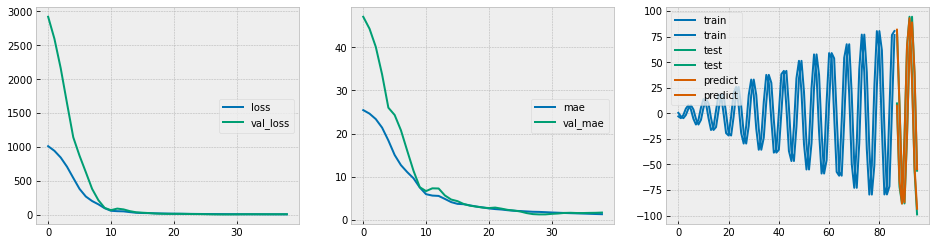

In [48]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

In [49]:
# Evaluate prediction
start = 12
y_true = [fct(start+n_in),fct(start+n_in+1)]
x_input = np.array([fct(x) for x in range(start, start+n_in)])
x_input = x_input.reshape((1, n_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[ 3.541137  -2.9333453]] [9.754317602356753, -4.606453066641045]


### Encoder-Decoder Model <span style="color:purple">(To Go Further)</span>

It's a model specifically developed for forecasting variable length output sequence. The model was designed for prediction problems where there are both input and output sequences, so-called sequence-to-sequence, or seq2seq problems, such as translating text from one language to another. As its name suggests, the model is comprised of two sub-models: the encoder and the decoder.

The encoder is a model responsible for reading and interpreting the input sequence. The output of the encoder is a fixed length vector that represents the model’s interpretation of the sequence. The encoder is traditionally a Vanilla LSTM model, although other encoder models can be used such as Stacked, Bidirectional, and CNN models.

In [50]:
n_features = 1 # stand for uni-variate time series

In [51]:
# Encoder part
inputs = Input(shape=(n_in, n_features))
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(inputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(outputs)
encoded = Bidirectional(LSTM(LSTM_SIZE, return_sequences=False, activation='relu'))(outputs)

The decoder uses the output of the encoder as an input.

* First, the fixed-length output of the encoder is repeated, once for each required time step in the output sequence.
* Then, this sequence is then provided to an LSTM decoder model. The model must output a value for each value in the output time step, which can be interpreted by a single output model.
* Then, we can use the same output layer or layers to make each one-step prediction in the output sequence. This can be achieved by wrapping the output part of the model in a TimeDistributed wrapper.

In [52]:
# Decoder part
from keras.layers import RepeatVector

outputs = RepeatVector(n_out)(encoded)
outputs = LSTM(LSTM_SIZE, activation='relu', return_sequences=True)(outputs)
predictions = TimeDistributed(Dense(1))(outputs)

In [53]:
# reshape input data from [samples, timesteps] into [samples, timesteps, features]
X_train = X.reshape((X.shape[0], X.shape[1], n_features))[:-SPLIT]
X_test = X.reshape((X.shape[0], X.shape[1], n_features))[-SPLIT:]

# reshape output data from [samples, timesteps] into [samples, timesteps, features]
y_train = y.reshape((y.shape[0], y.shape[1], n_features))[:-SPLIT]
y_test = y.reshape((y.shape[0], y.shape[1], n_features))[-SPLIT:]

print("X_train:",X_train.shape,"; X_test:", X_test.shape)
print("y_train:",y_train.shape,"   ; y_test:", y_test.shape)

X_train: (87, 3, 1) ; X_test: (9, 3, 1)
y_train: (87, 2, 1)    ; y_test: (9, 2, 1)


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 3, 60)            7680      
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 3, 60)            21840     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 60)               21840     
 onal)                                                           
                                                                 
 repeat_vector (RepeatVector  (None, 2, 60)            0         
 )                                                         

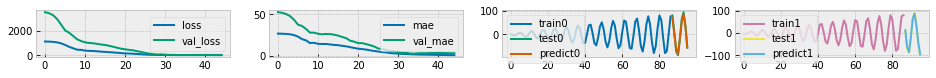

In [54]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

### Multiple Parallel Input and Multi-Step Output <span style="color:purple">(To Go Further)</span>

A problem with parallel time series may require the prediction of multiple time steps of each time series.

In [55]:
n_in, n_out = 6, 2

X, y = convert_data_multiplesparallelseries(dataset, n_in, n_out)
n_features = X.shape[-1] # in order to capture the multi-variate dimension

# Summarize the data
for i in range(3):
    print("-"*15)
    print("X:", X[i])
    print("y:", y[i])
print("...")

---------------
X: [[ 0.          0.          0.        ]
 [ 0.84147098  2.          2.84147098]
 [ 1.81859485  4.          5.81859485]
 [ 0.42336002  6.          6.42336002]
 [-3.02720998  8.          4.97279002]
 [-4.79462137 10.          5.20537863]]
y: [[-1.67649299 12.         10.32350701]
 [ 4.59890619 14.         18.59890619]]
---------------
X: [[ 0.84147098  2.          2.84147098]
 [ 1.81859485  4.          5.81859485]
 [ 0.42336002  6.          6.42336002]
 [-3.02720998  8.          4.97279002]
 [-4.79462137 10.          5.20537863]
 [-1.67649299 12.         10.32350701]]
y: [[ 4.59890619 14.         18.59890619]
 [ 7.91486597 16.         23.91486597]]
---------------
X: [[ 1.81859485  4.          5.81859485]
 [ 0.42336002  6.          6.42336002]
 [-3.02720998  8.          4.97279002]
 [-4.79462137 10.          5.20537863]
 [-1.67649299 12.         10.32350701]
 [ 4.59890619 14.         18.59890619]]
y: [[ 7.91486597 16.         23.91486597]
 [ 3.70906637 18.         21.709

We can use either the Vector Output or Encoder-Decoder LSTM to model this problem. In this case, we will use the Encoder-Decoder model.

In [56]:
# Encoder part
inputs = Input(shape=(n_in, n_features))
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(inputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(outputs)
encoded = Bidirectional(LSTM(LSTM_SIZE, return_sequences=False, activation='relu'))(outputs)

In [57]:
# Decoder part
from keras.layers import RepeatVector

outputs = RepeatVector(n_out)(encoded)
outputs = LSTM(LSTM_SIZE, activation='relu', return_sequences=True)(outputs)
predictions = TimeDistributed(Dense(n_features))(outputs)

In [58]:
# reshape input data from [samples, timesteps] into [samples, timesteps, features]
X_train = X.reshape((X.shape[0], X.shape[1], n_features))[:-SPLIT]
X_test = X.reshape((X.shape[0], X.shape[1], n_features))[-SPLIT:]

# reshape output data from [samples, timesteps] into [samples, timesteps, features]
y_train = y.reshape((y.shape[0], y.shape[1], n_features))[:-SPLIT]
y_test = y.reshape((y.shape[0], y.shape[1], n_features))[-SPLIT:]

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 6, 3)]            0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 6, 60)            8160      
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 6, 60)            21840     
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 60)               21840     
 onal)                                                           
                                                                 
 repeat_vector_1 (RepeatVect  (None, 2, 60)            0         
 or)                                                       

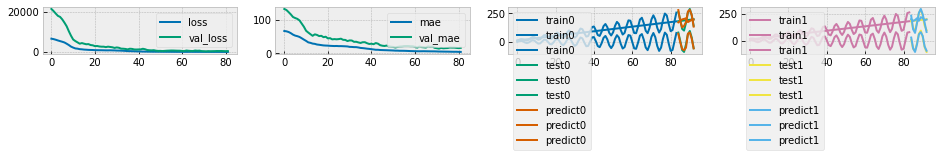

In [59]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

___

## <span style="color:purple">**Your Turn:** The `covid19` Dataset</span>

### Data Preparation

In [60]:
STATE = "New York"
covid = covid19[covid19["Province_State"]==STATE]

confirmed = np.array(covid['ConfirmedCases']).tolist()
fatalities = np.array(covid['Fatalities']).tolist()

testAndValid = 0.10
SPLIT = int(testAndValid*covid.shape[0])

### Univariate Forecasting

In [1]:
n_in, n_out = 30, 1
n_features = 1

#### Confirmed Cases

In [2]:
LSTM_SIZE = 50

inputs = Input(shape=(n_in, n_features))
outputs = LSTM(LSTM_SIZE, return_sequences=False,recurrent_activation='sigmoid',activation='relu')(inputs)
predictions = Dense(n_out, activation='linear')(outputs)

NameError: name 'Input' is not defined

In [63]:
X_confirmed, y_confirmed = convert_data_univariate(confirmed, n_in, n_out)
X_confirmed_train = X_confirmed.reshape((X_confirmed.shape[0], X_confirmed.shape[1], n_features))[:-SPLIT]
X_confirmed_test = X_confirmed.reshape((X_confirmed.shape[0], X_confirmed.shape[1], n_features))[-SPLIT:]
y_confirmed_train, y_confirmed_test = y_confirmed[:-SPLIT], y_confirmed[-SPLIT:]

print("Confirmed Cases:")
print("Train: Confirmed cases in "+STATE+": X_train.shape =",X_confirmed_train.shape,
      "y_train.shape =",y_confirmed_train.shape,"\n",
     "Test: Confirmed cases in "+STATE+": X_test.shape =",X_confirmed_test.shape,
      "y_test.shape =",y_confirmed_test.shape)

Confirmed Cases:
Train: Confirmed cases in New York: X_train.shape = (96, 8, 1) y_train.shape = (96, 1) 
 Test: Confirmed cases in New York: X_test.shape = (11, 8, 1) y_test.shape = (11, 1)


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 8, 1)]            0         
                                                                 
 lstm_20 (LSTM)              (None, 20)                1760      
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


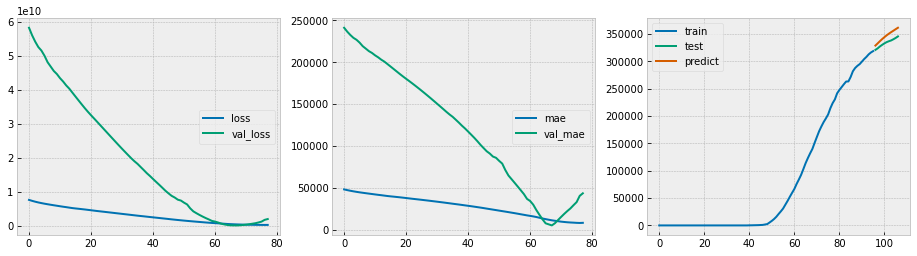

In [64]:
model = build_and_fit(inputs, predictions, 
                      X_confirmed_train, y_confirmed_train, X_confirmed_test, y_confirmed_test)

#### Fatalities

In [65]:
LSTM_SIZE = 30

inputs = Input(shape=(n_in, n_features))
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(inputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(outputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=False, activation='relu'))(outputs)
predictions = Dense(n_out, activation='linear')(outputs)

In [66]:
# Fatalities
X_fatalities, y_fatalities = convert_data_univariate(fatalities, n_in, n_out)
X_fatalities_train = X_fatalities.reshape((X_fatalities.shape[0], X_fatalities.shape[1], n_features))[:-SPLIT]
X_fatalities_test = X_fatalities.reshape((X_fatalities.shape[0], X_fatalities.shape[1], n_features))[-SPLIT:]
y_fatalities_train, y_fatalities_test = y_fatalities[:-SPLIT], y_fatalities[-SPLIT:]

print("Fatalities:")
print("Train: Fatalities in "+STATE+": X_train.shape =",X_fatalities_train.shape,
      "y_train.shape =",y_fatalities_train.shape,"\n",
     "Test: Fatalities in "+STATE+": X_test.shape =",X_fatalities_test.shape,
      "y_test.shape =",y_fatalities_test.shape)

Fatalities:
Train: Fatalities in New York: X_train.shape = (96, 8, 1) y_train.shape = (96, 1) 
 Test: Fatalities in New York: X_test.shape = (11, 8, 1) y_test.shape = (11, 1)


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 8, 1)]            0         
                                                                 
 bidirectional_15 (Bidirecti  (None, 8, 60)            7680      
 onal)                                                           
                                                                 
 bidirectional_16 (Bidirecti  (None, 8, 60)            21840     
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 60)               21840     
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 1)                 61        
                                                          

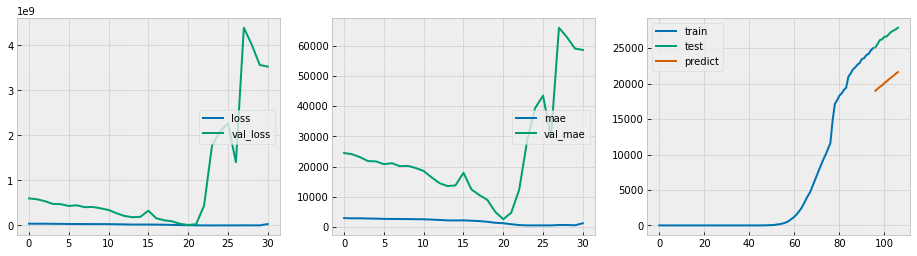

In [67]:
model = build_and_fit(inputs, predictions, 
                      X_fatalities_train, y_fatalities_train, X_fatalities_test, y_fatalities_test)

### Multivariate Forecasting

In [68]:
n_in, n_out = 6, 1
n_features = 2

In [69]:
# Convert to [rows, columns] structure
data = np.hstack((np.array(confirmed).reshape((len(confirmed), 1)),
                 np.array(fatalities).reshape((len(fatalities), 1))))

X, y = convert_data_multiplesparallelseries(data, n_in, n_out)
if n_out==1:
    y = y.reshape(y.shape[0], y.shape[-1])

In [70]:
inputs = Input(shape=(n_in, n_features))
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(inputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(outputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=False, activation='relu'))(outputs)
predictions = Dense(n_features, activation='linear')(outputs)

In [71]:
X_train, X_test = X[:-SPLIT], X[-SPLIT:]
y_train, y_test = y[:-SPLIT], y[-SPLIT:]

print("X_train:",X_train.shape,"; X_test:", X_test.shape)
print("y_train:",y_train.shape,"   ; y_test:", y_test.shape)

X_train: (98, 6, 2) ; X_test: (11, 6, 2)
y_train: (98, 2)    ; y_test: (11, 2)


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 6, 2)]            0         
                                                                 
 bidirectional_18 (Bidirecti  (None, 6, 60)            7920      
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 6, 60)            21840     
 onal)                                                           
                                                                 
 bidirectional_20 (Bidirecti  (None, 60)               21840     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 2)                 122       
                                                          

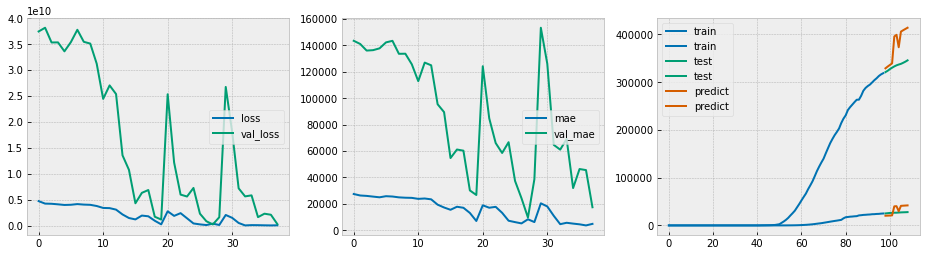

In [72]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

### Multistep Univariate Forecasting

In [73]:
n_in, n_out = 6, 3
n_features = 1

#### Confirmed Cases

In [74]:
LSTM_SIZE = 20

inputs = Input(shape=(n_in, n_features))
outputs = LSTM(LSTM_SIZE, return_sequences=False,recurrent_activation='sigmoid',activation='relu')(inputs)
predictions = Dense(n_out, activation='linear')(outputs)

In [75]:
X_confirmed, y_confirmed = convert_data_univariate(confirmed, n_in, n_out)
X_confirmed_train = X_confirmed.reshape((X_confirmed.shape[0], X_confirmed.shape[1], n_features))[:-SPLIT]
X_confirmed_test = X_confirmed.reshape((X_confirmed.shape[0], X_confirmed.shape[1], n_features))[-SPLIT:]
y_confirmed_train, y_confirmed_test = y_confirmed[:-SPLIT], y_confirmed[-SPLIT:]

print("Confirmed Cases:")
print("Train: Confirmed cases in "+STATE+": X_train.shape =",X_confirmed_train.shape,
      "y_train.shape =",y_confirmed_train.shape,"\n",
     "Test: Confirmed cases in "+STATE+": X_test.shape =",X_confirmed_test.shape,
      "y_test.shape =",y_confirmed_test.shape)

Confirmed Cases:
Train: Confirmed cases in New York: X_train.shape = (96, 6, 1) y_train.shape = (96, 3) 
 Test: Confirmed cases in New York: X_test.shape = (11, 6, 1) y_test.shape = (11, 3)


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 6, 1)]            0         
                                                                 
 lstm_27 (LSTM)              (None, 20)                1760      
                                                                 
 dense_13 (Dense)            (None, 3)                 63        
                                                                 
Total params: 1,823
Trainable params: 1,823
Non-trainable params: 0
_________________________________________________________________


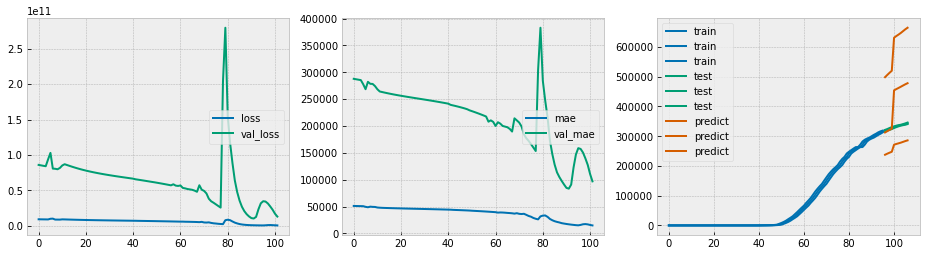

In [76]:
model = build_and_fit(inputs, predictions, 
                      X_confirmed_train, y_confirmed_train, X_confirmed_test, y_confirmed_test)

#### Fatalities

In [77]:
#### Confirmed Cases...